# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
        self.output_layer = DenseLayer(n_hidden_2, num_classes)
    
    
    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.output_layer(x, activation=1)
        return x


In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    predicted_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicted_classes, tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)
    
    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
        
        trainable_variables = [neural_net.layer_1.w, neural_net.layer_1.b,
                               neural_net.layer_2.w, neural_net.layer_2.b,
                               neural_net.output_layer.w, neural_net.output_layer.b]
        
        gradients = g.gradient(loss, trainable_variables)
        
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        
        acc = accuracy(pred, batch_y)
        
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

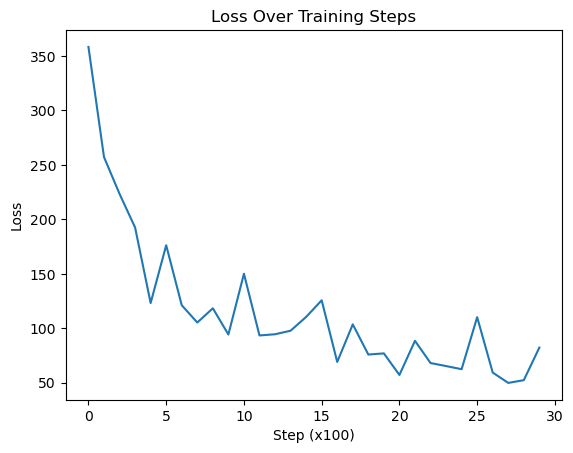

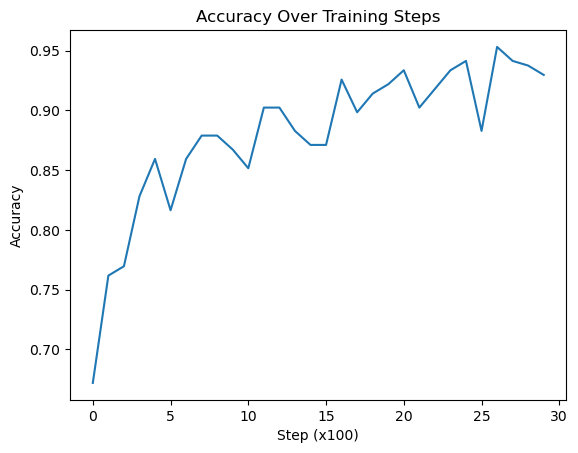

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title("Loss Over Training Steps")
plt.xlabel("Step (x100)")
plt.ylabel("Loss")
plt.show()

plt.plot(accuracy_history)
plt.title("Accuracy Over Training Steps")
plt.xlabel("Step (x100)")
plt.ylabel("Accuracy")
plt.show()


In [9]:
def evaluate_model(neural_net, x_test, y_test):
    total_accuracy = 0
    total_samples = 0

    predictions = neural_net(x_test)
    test_accuracy = accuracy(predictions, y_test)
    return test_accuracy.numpy()

test_accuracy = evaluate_model(neural_net, x_test, y_test)

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9047


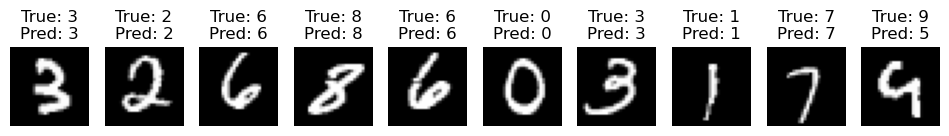

Correct Predictions: 9
Incorrect Predictions: 1


In [13]:
def test_single_images(model, x_test, y_test, num_images=5):
    indices = random.sample(range(len(x_test)), num_images)
    selected_images = x_test[indices]
    true_labels = y_test[indices]
    predictions = model(selected_images)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(selected_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

    errors = sum(true_labels != predicted_labels)
    print(f"Correct Predictions: {num_images - errors}")
    print(f"Incorrect Predictions: {errors}")

test_single_images(neural_net, x_test, y_test, num_images=10)

In [14]:
predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

report = classification_report(y_test, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.98      0.97      0.97      1135
           2       0.86      0.90      0.88      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.91      0.90       982
           5       0.89      0.86      0.88       892
           6       0.93      0.92      0.92       958
           7       0.91      0.91      0.91      1028
           8       0.87      0.85      0.86       974
           9       0.88      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Висновок:

### Модель змогла передбачити 9 з 10 картинок, а за показниками точності передбачень на тестовій вибірці, модель навчилася розпізнавати цифри правильно у 90% випадків, а це значить, що модель помиляється у 10% випадків.

### Дивлячись на метрику classification report, можна побачити, що модель помиляється найбільше з цифрою 8, так як результат f1-score у неї найнижчий - 86%. Цифру 1 передбачує модель найкраще з усіх, з результатом f1-score - 97%